In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:

import pandas as pd  # import the pandas library for data handling

file_path = '/content/drive/MyDrive/Colab Notebooks/reddit_user_data_count_5000.csv'  # set the path to the csv file

df = pd.read_csv(file_path)  # read the csv file and store it in a dataframe

df.head()  # show the first 5 rows of the dataframe


,user,subreddit,count
0,------Username------,AskReddit,20
1,------Username------,Barca,9
2,------Username------,FIFA,4
3,------Username------,MMA,5
4,------Username------,RioGrandeValley,3


In [6]:
df.info()  # shows basic info about the dataframe like column names, non-null counts, and data types

df.describe(include='all')  # gives summary stats for all columns, including non-numeric ones


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   user       5000 non-null   object
 1   subreddit  5000 non-null   object
 2   count      5000 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 117.3+ KB


,user,subreddit,count
count,5000,5000,5000.000000
unique,124,2830,NaN
top,-j4ckK-,AskReddit,NaN
freq,342,64,NaN
mean,NaN,NaN,12.037000
std,NaN,NaN,48.388754
min,NaN,NaN,1.000000
25%,NaN,NaN,1.000000
50%,NaN,NaN,2.000000
75%,NaN,NaN,6.000000


In [8]:
print("Null values per column:\n", df.isnull().sum())  # check how many null (missing) values are in each column

print("\nDuplicate rows:", df.duplicated().sum())  # check how many duplicate rows are in the dataframe


Null values per column:
 user         0
subreddit    0
count        0
dtype: int64

Duplicate rows: 0


In [12]:
# drop rows where 'user' or 'subreddit' is null (missing)
df = df.dropna(subset=["user", "subreddit"])

# make sure the 'user' and 'subreddit' columns are treated as strings
df["user"] = df["user"].astype(str)
df["subreddit"] = df["subreddit"].astype(str)

# optional step: convert all subreddit names to lowercase to keep things consistent
df["subreddit"] = df["subreddit"].str.lower()


In [13]:
print(f"Number of unique users: {df['user'].nunique()}")
print(f"Number of unique subreddits: {df['subreddit'].nunique()}")
print(f"Total interactions: {len(df)}")


Number of unique users: 124
Number of unique subreddits: 2830
Total interactions: 5000


In [20]:
# Build Bipartite Graph

import networkx as nx
from networkx.algorithms import bipartite

# create an empty graph object for the bipartite graph
B = nx.Graph()

# get all unique subreddits and add them as one set of nodes (labelled bipartite=0)
subreddits = df['subreddit'].unique()
B.add_nodes_from(subreddits, bipartite=0)

# get all unique users and add them as the other set of nodes (labelled bipartite=1)
users = df['user'].unique()
B.add_nodes_from(users, bipartite=1)

# create edges between users and subreddits based on their interactions
edges = list(zip(df['user'], df['subreddit']))
B.add_edges_from(edges)

# print basic stats about the graph
print(f"Total bipartite nodes: {B.number_of_nodes()}")  # total number of nodes (users + subreddits)
print(f"Total bipartite edges: {B.number_of_edges()}")  # total number of connections (edges)



Total bipartite nodes: 2954
Total bipartite edges: 5000


In [22]:
# project bipartite graph onto subreddit-subreddit network

# get only the subreddit nodes (bipartite=0)
subreddit_nodes = [n for n, d in B.nodes(data=True) if d['bipartite'] == 0]

# create a weighted projection where subreddits are connected if they share users
G = bipartite.weighted_projected_graph(B, subreddit_nodes)

# print info about the projected subreddit graph
print(f"Projected subreddit network:")
print(f"Nodes: {G.number_of_nodes()}")  # number of subreddits
print(f"Edges: {G.number_of_edges()}")  # number of connections between subreddits


Projected subreddit network:
Nodes: 2830
Edges: 202402


In [25]:
print(f"Number of nodes: {G.number_of_nodes()}")  # total number of subreddit nodes
print(f"Number of edges: {G.number_of_edges()}")  # total number of edges between subreddits

# find all connected components (groups of connected subreddits)
components = list(nx.connected_components(G))

# get the largest connected group
largest_cc = max(components, key=len)

print(f"Number of connected components: {len(components)}")  # how many separate groups are in the network
print(f"Largest component size: {len(largest_cc)}")  # number of nodes in the biggest group

# calculate the average clustering coefficient (how connected a node's neighbors are)
avg_clustering = nx.average_clustering(G)
print(f"Average clustering coefficient: {avg_clustering:.4f}")

# calculate the average shortest path length within the largest connected component
G_largest = G.subgraph(largest_cc)  # make a subgraph from the largest component
avg_path_length = nx.average_shortest_path_length(G_largest)
print(f"Average shortest path length (largest component): {avg_path_length:.4f}")


Number of nodes: 2830
Number of edges: 202402
Number of connected components: 4
Largest component size: 2813
Average clustering coefficient: 0.8857
Average shortest path length (largest component): 2.0993


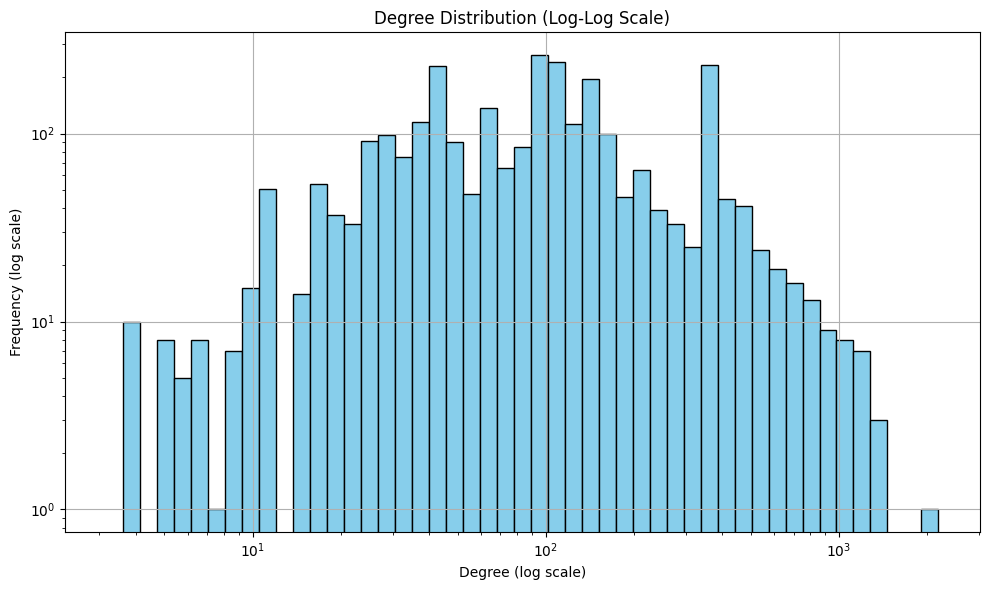

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# get the degree (number of connections) for each subreddit node
degrees = [d for n, d in G.degree()]
max_degree = max(degrees)  # find the max degree to set bin range

# plot the degree distribution on a log-log scale
plt.figure(figsize=(10, 6))
plt.hist(degrees, bins=np.logspace(0.5, np.log10(max_degree), 50), color='skyblue', edgecolor='black')  # use log-spaced bins
plt.xscale('log')  # log scale for x-axis (degree)
plt.yscale('log')  # log scale for y-axis (frequency)
plt.xlabel("Degree (log scale)")
plt.ylabel("Frequency (log scale)")
plt.title("Degree Distribution (Log-Log Scale)")
plt.grid(True)
plt.tight_layout()
plt.show()  # show the plot


Generating spring layout for the network...


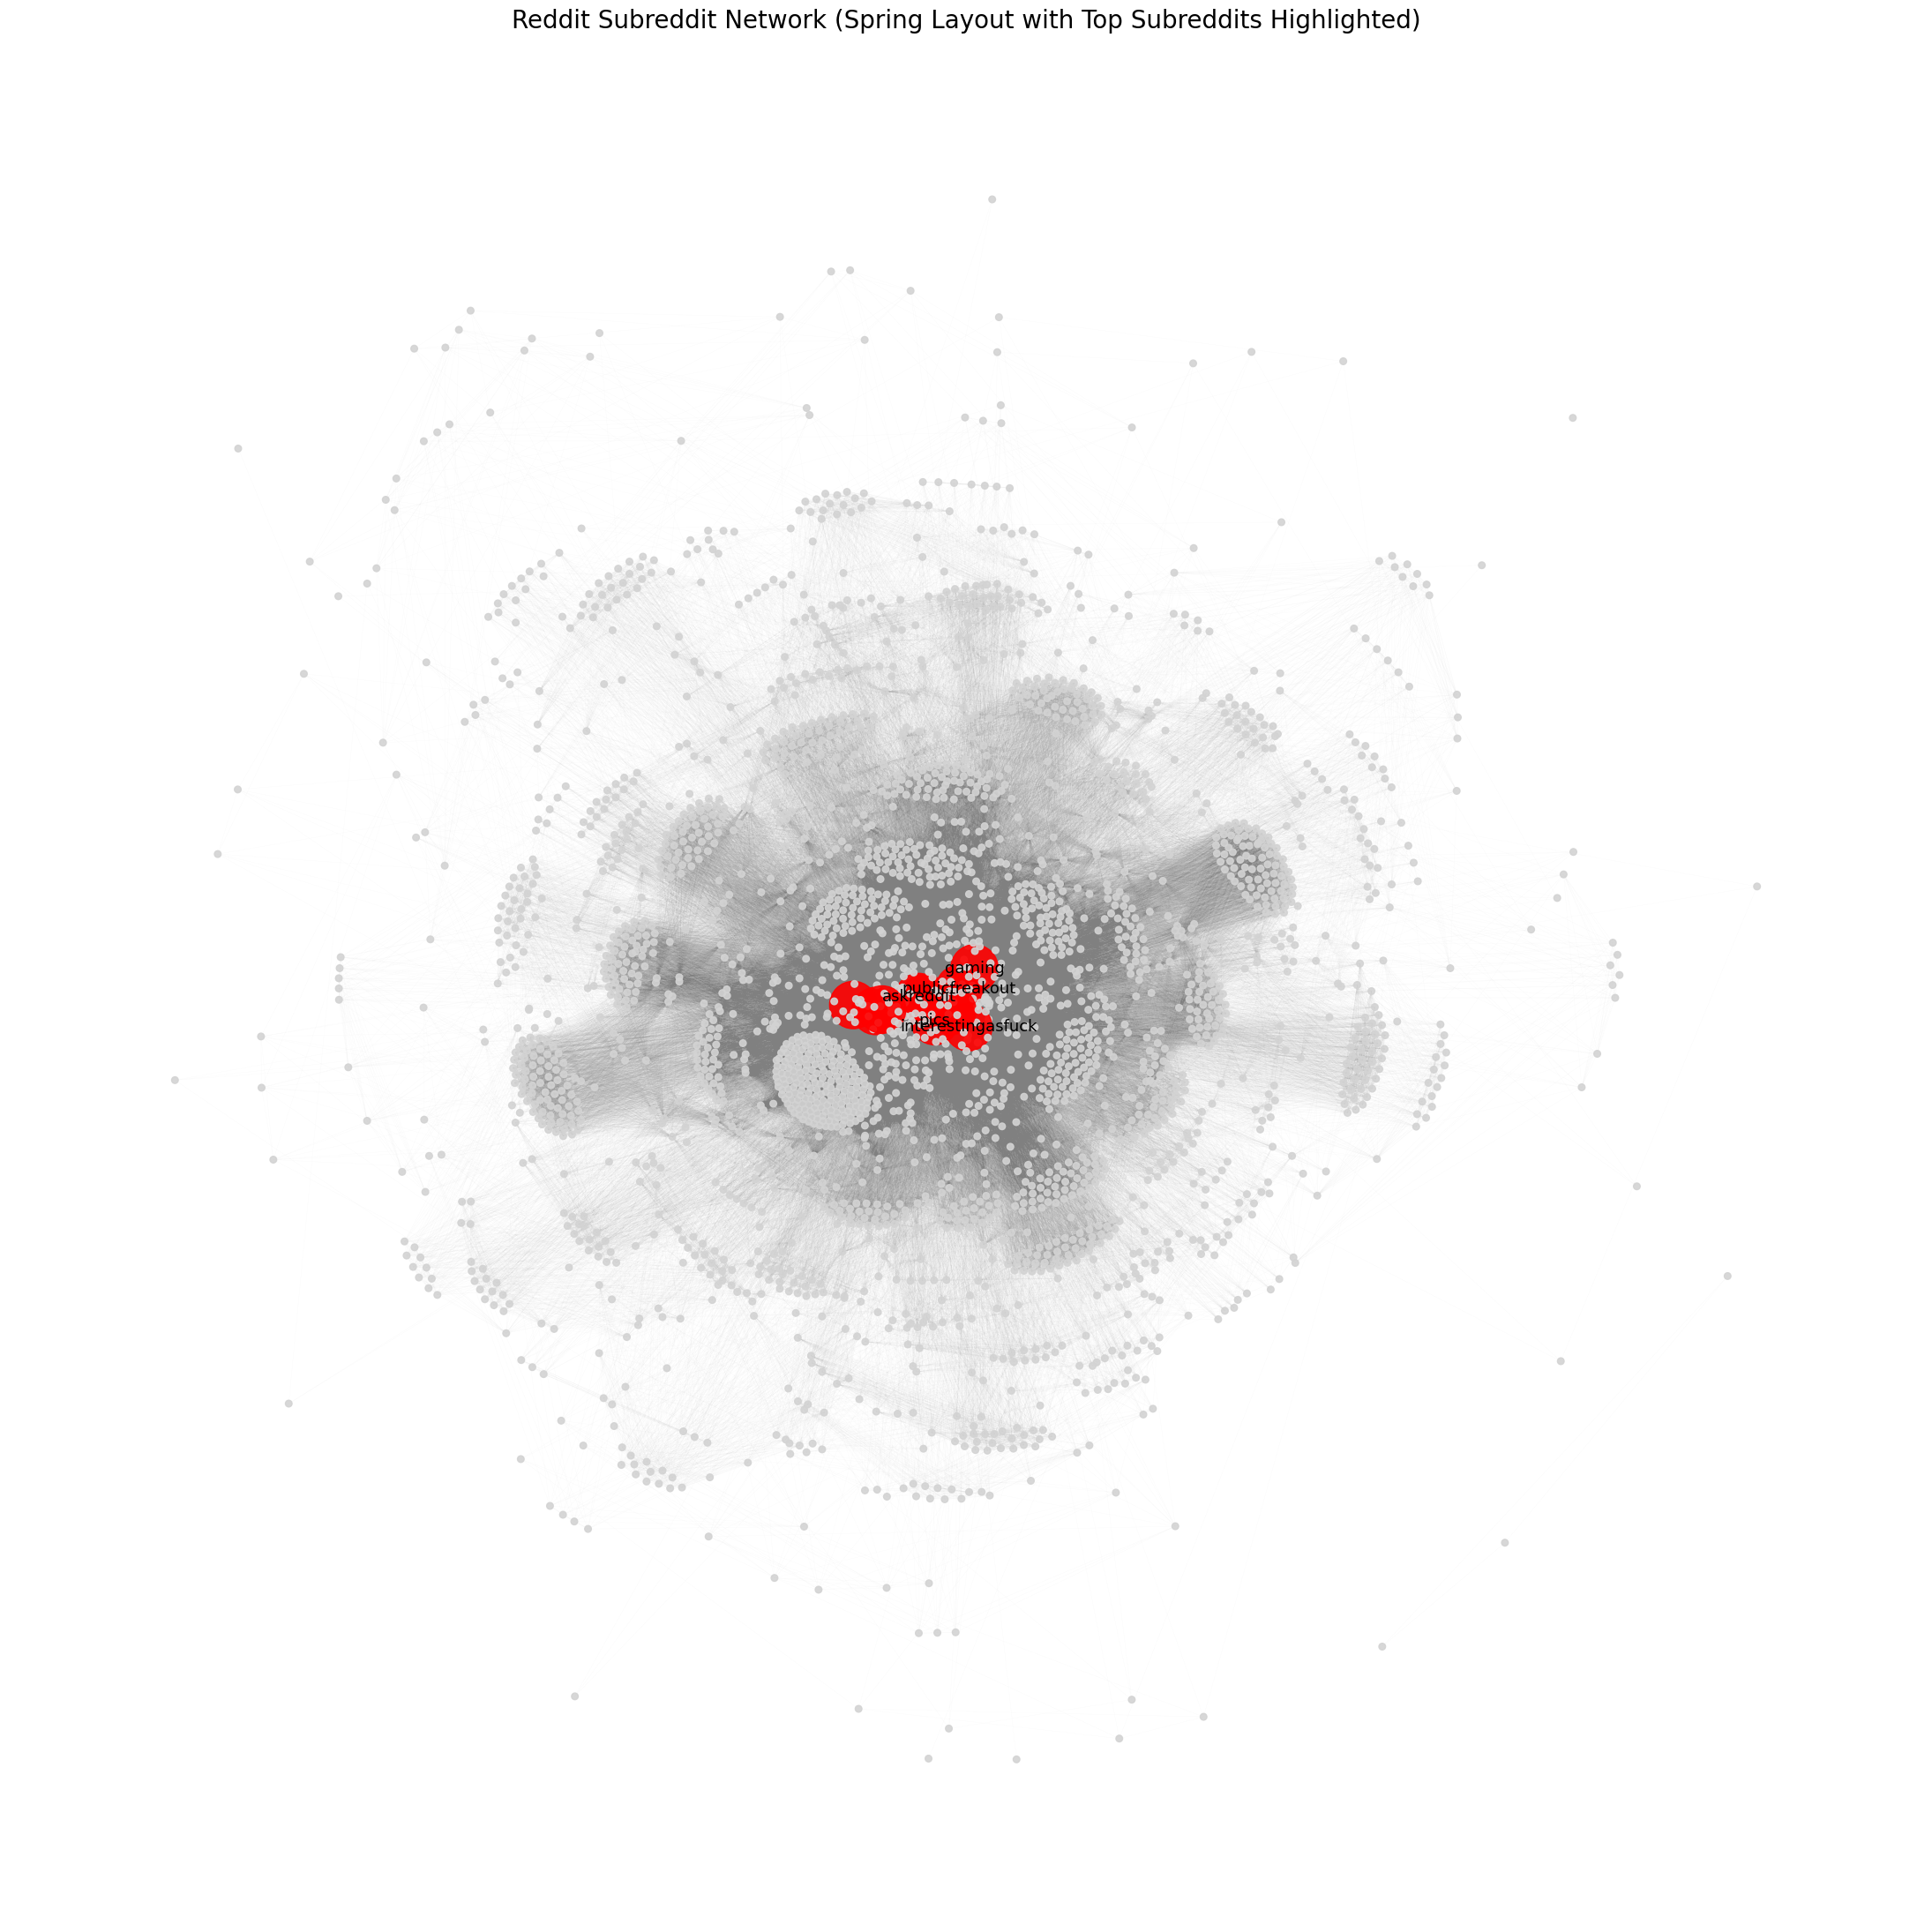

In [28]:


# step 1: remove self-loops to make the layout cleaner
G_small = G.copy()
G_small.remove_edges_from(nx.selfloop_edges(G_small))

# step 2: generate a spring layout for better visualization
print("Generating spring layout for the network...")
pos = nx.spring_layout(G_small, seed=42, k=0.5, iterations=100)

# step 3: find the top subreddits based on degree centrality
degree_centrality = nx.degree_centrality(G_small)
top_10_subreddits = sorted(degree_centrality, key=degree_centrality.get, reverse=True)[:10]

# set color and size based on importance
node_colors = ["red" if node in top_10_subreddits else "lightgray" for node in G_small.nodes()]
node_sizes = [1500 if node in top_10_subreddits else 30 for node in G_small.nodes()]
labels = {node: node for node in top_10_subreddits[:5]}  # only label top 5 for readability

# step 4: draw the graph
plt.figure(figsize=(22, 22))
nx.draw_networkx_edges(G_small, pos, alpha=0.04, edge_color="gray", width=0.3)
nx.draw_networkx_nodes(G_small, pos, node_size=node_sizes, node_color=node_colors, alpha=0.9)
nx.draw_networkx_labels(G_small, pos, labels, font_size=13, font_color="black")

plt.title("Reddit Subreddit Network (Spring Layout with Top Subreddits Highlighted)", fontsize=20)
plt.axis('off')
plt.tight_layout()
plt.savefig("reddit_subreddit_network_clean.png", dpi=300)
plt.show()


In [29]:
import networkx as nx
# using only the largest connected component(99.4%) to make the layout cleaner
largest_cc = max(nx.connected_components(G), key=len)
G_largest = G.subgraph(largest_cc).copy()

# exportiing the graph as a GraphML file so it can be used in Gephi
nx.write_graphml(G_largest, "reddit_subreddit_network.graphml")



In [30]:
from google.colab import files
files.download("reddit_subreddit_network.graphml")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [33]:

# assuming G is subreddit-subreddit network
degree_centrality = nx.degree_centrality(G)

# sort and get the top 10 subreddits with the highest degree centrality
top_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]

print("top 10 subreddits by degree centrality:")
for subreddit, score in top_degree:
    print(f"{subreddit}: {score:.4f}")



top 10 subreddits by degree centrality:
askreddit: 0.7724
pics: 0.5048
gaming: 0.4715
interestingasfuck: 0.4563
publicfreakout: 0.4486
funny: 0.4383
nextfuckinglevel: 0.4366
unpopularopinion: 0.4206
memes: 0.4086
aww: 0.4044


In [36]:
# calculate betweenness centrality using sampling (k=1000 for faster results on large graphs)
betweenness = nx.betweenness_centrality(G, k= 1000, seed= 50)

# sort and get the top 10 subreddits with the highest betweenness centrality
top_betweenness = sorted(betweenness.items(), key=lambda x: x[1], reverse=True)[:10]

print("top 10 subreddits by betweenness centrality:")
for subreddit, score in top_betweenness:
    print(f"{subreddit}: {score:.4f}")

top 10 subreddits by betweenness centrality:
askreddit: 0.1524
gaming: 0.0288
memes: 0.0281
nextfuckinglevel: 0.0212
pics: 0.0205
unpopularopinion: 0.0203
politics: 0.0202
interestingasfuck: 0.0202
movies: 0.0197
cringetopia: 0.0177


In [38]:
# match the size of the real subreddit network
n = G.number_of_nodes()
m = G.number_of_edges()

# calculate edge probability p for the ER (Erdos–Renyi) model
# formula: p = 2m / (n(n - 1)), since undirected
p = (2 * m) / (n * (n - 1))

# generate an ER random graph with same number of nodes and similar number of edges
G_er = nx.erdos_renyi_graph(n=n, p=p, seed=42)

print(f"ER Graph: {G_er.number_of_nodes()} nodes, {G_er.number_of_edges()} edges")


ER Graph: 2830 nodes, 202647 edges


In [41]:
# calculate average clustering coefficient for the ER random graph
er_clustering = nx.average_clustering(G_er)
print(f"ER clustering coefficient: {er_clustering:.4f}")

# find connected components in the ER graph
er_components = list(nx.connected_components(G_er))
largest_er_cc = max(er_components, key=len)

print(f"ER connected components: {len(er_components)}")  # total number of components
print(f"ER largest component size: {len(largest_er_cc)}")  # number of nodes in the biggest component

# calculate average shortest path length in the largest component
G_er_largest = G_er.subgraph(largest_er_cc)
er_path_length = nx.average_shortest_path_length(G_er_largest)
print(f"ER avg shortest path (largest component): {er_path_length:.4f}")



ER clustering coefficient: 0.0505
ER connected components: 1
ER largest component size: 2830
ER avg shortest path (largest component): 1.9501


In [43]:
print("pics:", betweenness.get('pics'))


pics: 0.020549960692338116


In [45]:

# step 1: get the degree sequence from real network
degree_sequence = [d for n, d in G.degree()]

# step 2: generate a configuration model graph with the same degree distribution
G_config = nx.configuration_model(degree_sequence, seed=42)

# step 3: convert to a simple graph (remove self-loops and parallel edges)
G_config = nx.Graph(G_config)
G_config.remove_edges_from(nx.selfloop_edges(G_config))

# step 4: calculate the average clustering coefficient
clustering_config = nx.average_clustering(G_config)
print(f"degree-preserving clustering coefficient: {clustering_config:.4f}")

# step 5: calculate average shortest path length using only the largest connected component
components_config = list(nx.connected_components(G_config))
largest_config = max(components_config, key=len)
G_config_largest = G_config.subgraph(largest_config)

path_length_config = nx.average_shortest_path_length(G_config_largest)
print(f"degree-preserving avg shortest path length: {path_length_config:.4f}")



degree-preserving clustering coefficient: 0.1913
degree-preserving avg shortest path length: 2.0627


In [ ]:
nx.write_graphml(G_er, "reddit_er_random.graphml")
from google.colab import files
files.download("reddit_er_random.graphml")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
nx.write_graphml(G_config, "reddit_degree_preserving.graphml")
files.download("reddit_degree_preserving.graphml")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Calculating best minimal value for power law fit
power-law alpha: 3.5929
power-law xmin: 409.0

power-law vs. exponential
log-likelihood ratio (R): -0.6203
p-value: 0.8650


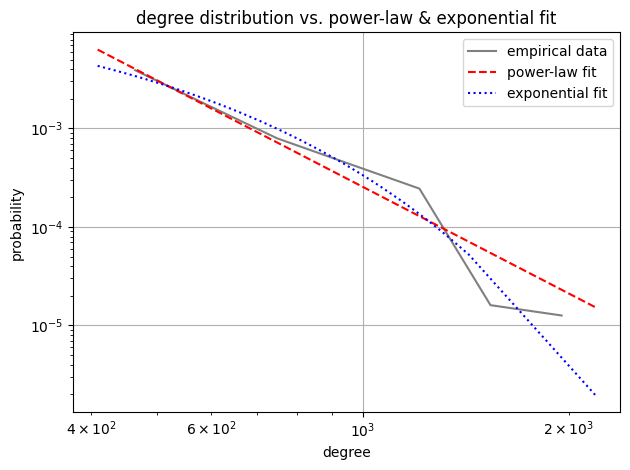

In [47]:
!pip install powerlaw  # install the powerlaw package

import powerlaw
import matplotlib.pyplot as plt

# get the degree sequence, ignoring nodes with degree 0
degree_sequence = [d for n, d in G.degree() if d > 0]

# fit a power-law model to the degree data
fit = powerlaw.Fit(degree_sequence, discrete=True)

# print the alpha value (slope) and xmin (cutoff point where power-law behavior starts)
print(f"power-law alpha: {fit.power_law.alpha:.4f}")
print(f"power-law xmin: {fit.power_law.xmin}")

# compare power-law fit to an exponential fit
R_exp, p_exp = fit.distribution_compare('power_law', 'exponential')
print(f"\npower-law vs. exponential")
print(f"log-likelihood ratio (R): {R_exp:.4f}")  # positive R means power-law is better
print(f"p-value: {p_exp:.4f}")  # lower p means more confident in the result

# plot the degree distribution and both fits (power-law and exponential)
fig = fit.plot_pdf(color='gray', label='empirical data')
fit.power_law.plot_pdf(color='red', linestyle='--', label='power-law fit', ax=fig)
fit.exponential.plot_pdf(color='blue', linestyle=':', label='exponential fit', ax=fig)

plt.legend()
plt.title("degree distribution vs. power-law & exponential fit")
plt.xlabel("degree")
plt.ylabel("probability")
plt.grid(True)
plt.tight_layout()
plt.show()


Generating 100 ER graphs and computing metrics...


100%|██████████| 100/100 [1:14:35<00:00, 44.75s/it]



--- ER Ensemble Results (100 Graphs) ---
Clustering Coefficient: 0.0506 ± 0.0001
Avg Shortest Path Length: 1.9501 ± 0.0001


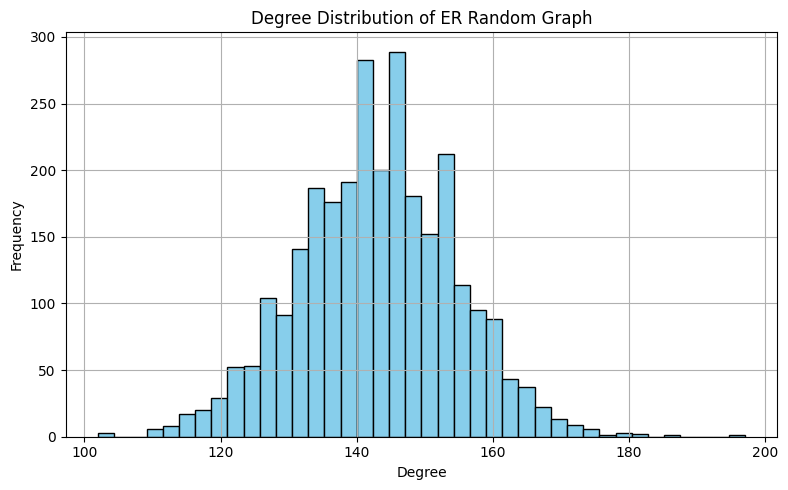

In [2]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


n = 2830  # number of nodes
m = 202402  # number of edges
p = (2 * m) / (n * (n - 1))  # probability for ER model

# Store results
clustering_vals = []
path_lengths = []

print("Generating 100 ER graphs and computing metrics...")

for _ in tqdm(range(100)):
    # Generate ER graph
    G_er = nx.erdos_renyi_graph(n=n, p=p)

    # Compute clustering coefficient
    clustering_vals.append(nx.average_clustering(G_er))

    # Get the largest connected component
    largest_cc = max(nx.connected_components(G_er), key=len)
    G_lcc = G_er.subgraph(largest_cc)

    # Compute average shortest path length (only for LCC)
    if nx.is_connected(G_lcc):
        path_lengths.append(nx.average_shortest_path_length(G_lcc))

# Results
avg_clustering = np.mean(clustering_vals)
std_clustering = np.std(clustering_vals)
avg_path = np.mean(path_lengths)
std_path = np.std(path_lengths)

print("\n--- ER Ensemble Results (100 Graphs) ---")
print(f"Clustering Coefficient: {avg_clustering:.4f} ± {std_clustering:.4f}")
print(f"Avg Shortest Path Length: {avg_path:.4f} ± {std_path:.4f}")

# Plot degree distribution of the first ER graph
G_sample = nx.erdos_renyi_graph(n=n, p=p)
degree_sequence = [d for n, d in G_sample.degree() if d > 0]

plt.figure(figsize=(8, 5))
plt.hist(degree_sequence, bins=40, color='skyblue', edgecolor='black')
plt.title("Degree Distribution of ER Random Graph")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.tight_layout()
plt.grid(True)
plt.show()
